In [12]:
import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('../pruebillas.ipynb'), '..'))
os.chdir(root_dir)

sys.path.insert(0, os.path.join(root_dir, 'src'))

In [13]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover, plot_heatmaps, resample_apply, barssince
import pandas as pd
import talib as ta
import pandas_ta as pandas_ta
import numpy as np
import matplotlib.pyplot as plt
from backtesting import Strategy
import plotly.express as px
from datetime import datetime
import MetaTrader5 as mt5
import itertools
import yfinance as yf
from datetime import datetime
import MetaTrader5 as mt5
import pandas as pd
import pytz

import random
random.seed(42)

In [14]:
# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()
 
# get all symbols
symbols = mt5.symbols_get()


groups = []
for symbol in symbols:
    group = symbol.path.split('\\')[0]
    if not group in groups:
        groups.append(group)
groups


['Forex_Indicator',
 'CryptoCross_grp',
 'Crypto_group',
 'Energies_group',
 'Forex_group',
 'Indices_group',
 'Stocks_group']

In [15]:
# tickers = ['NTESm', 'NFLXm', 'Vm', 'ADPm']

tickers = [symbol.path.split('\\')[1] for symbol in symbols if 'Stocks_group' in symbol.path]
# tickers = [ticker for ticker in tickers if ticker == 'EURUSDm']
print(tickers)

['AAPLm', 'ABBVm', 'ABTm', 'ADBEm', 'ADPm', 'AMDm', 'AMGNm', 'AMTm', 'AMZNm', 'ATVIm', 'AVGOm', 'BAm', 'BABAm', 'BACm', 'BIIBm', 'BMYm', 'Cm', 'CHTRm', 'CMCSAm', 'CMEm', 'COSTm', 'CSCOm', 'CSXm', 'CVSm', 'EAm', 'EBAYm', 'EQIXm', 'Fm', 'FBm', 'GILDm', 'GOOGLm', 'HDm', 'IBMm', 'INTCm', 'INTUm', 'ISRGm', 'JNJm', 'JPMm', 'KOm', 'LINm', 'LLYm', 'LMTm', 'MAm', 'MCDm', 'MDLZm', 'MMMm', 'MOm', 'MRKm', 'MSm', 'MSFTm', 'NFLXm', 'NKEm', 'NVDAm', 'ORCLm', 'PEPm', 'PFEm', 'PGm', 'PMm', 'PYPLm', 'REGNm', 'SBUXm', 'Tm', 'TMOm', 'TMUSm', 'TSLAm', 'UNHm', 'UPSm', 'Vm', 'VRTXm', 'VZm', 'WFCm', 'WMTm', 'XOMm', 'AMCm', 'BBm', 'BBBYm', 'BEKEm', 'BIDUm', 'BILIm', 'BRQSm', 'BYNDm', 'CANm', 'EDUm', 'FTNTm', 'FUTUm', 'IQm', 'JDm', 'LIm', 'NIOm', 'NTESm', 'PDDm', 'RLXm', 'TALm', 'TIGRm', 'TMEm', 'TSMm', 'VIPSm', 'XPEVm', 'YUMCm', 'ZTOm', 'METAm']


In [16]:
intervals = [
    # mt5.TIMEFRAME_M1,
    # mt5.TIMEFRAME_M2,
    # mt5.TIMEFRAME_D1,
    # mt5.TIMEFRAME_M3,
    # mt5.TIMEFRAME_M4,
    # mt5.TIMEFRAME_M5,
    mt5.TIMEFRAME_M15,
    mt5.TIMEFRAME_M30,
    mt5.TIMEFRAME_H1,
    mt5.TIMEFRAME_H2,
    mt5.TIMEFRAME_H4,
    # mt5.TIMEFRAME_M30,
]

parameter_combinations = list(itertools.product(
    tickers, intervals
))

symbols = {}

print("MetaTrader5 package author: ", mt5.__author__)
print("MetaTrader5 package version: ", mt5.__version__)

# Establecer conexión con el terminal de MetaTrader 5
if not mt5.initialize():
    raise Exception("initialize() failed, error code =", mt5.last_error())

# Establecer la zona horaria a UTC
timezone = pytz.timezone("Etc/UTC")

# Crear objetos 'datetime' en zona horaria UTC
utc_from = datetime(2021, 1, 1, tzinfo=timezone)
utc_to = datetime(2024, 9, 1, tzinfo=timezone)

for ticker, interval in parameter_combinations:
    # Obtener las tasas históricas
    rates = mt5.copy_rates_range(ticker, interval, utc_from, utc_to)
    
    # Crear DataFrame con las tasas
    df = pd.DataFrame(rates)
    
    # Convertir el tiempo de segundos a formato datetime
    df['time'] = pd.to_datetime(df['time'], unit='s')


    # Renombrar columnas para el ticker principal
    df = df.rename(columns={
        'time': 'Date',
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'close': 'Close',
        'tick_volume': 'Volume'
    }).set_index('Date')


    if ticker not in symbols.keys():
        symbols[ticker] = {}
        symbols[ticker][interval] = {}

    symbols[ticker][interval] = df


# Cerrar la conexión con MetaTrader 5
mt5.shutdown()

# Mostrar el DataFrame final

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.4288


True

In [17]:
max_start_date = None
intervals_start_dates = {}

for interval in intervals:
    for ticker in tickers:
        if not max_start_date or symbols[ticker][interval].index.min() > max_start_date:
            max_start_date = symbols[ticker][interval].index.min()
        
    intervals_start_dates[interval] = max_start_date

intervals_start_dates



{15: Timestamp('2021-10-27 17:15:00'),
 30: Timestamp('2021-10-27 17:15:00'),
 16385: Timestamp('2021-10-27 17:15:00'),
 16386: Timestamp('2021-10-27 17:15:00'),
 16388: Timestamp('2021-10-27 17:15:00')}

In [18]:
class Bbands(Strategy):
    risk=3

    def init(self):
        self.sma_200 = self.I(
            ta.SMA, self.data.Close, timeperiod=200
        )

        self.upper_band, self.middle_band, self.lower_band = self.I(
            ta.BBANDS, self.data.Close, timeperiod=50
        )

    def next(self):
        actual_close = self.data.Close[-1]

        if self.position:
            first_trade = self.trades[0]

            first_trade_time = first_trade.entry_time
            if pd.api.types.is_datetime64_any_dtype(first_trade_time):
                if first_trade_time.tzinfo is None:
                    first_trade_time = first_trade_time

            today = self.data.index[-1]

            # Calcular el tiempo en la posición
            time_in_position = (today - first_trade_time).days

            if self.position.is_long:
                if actual_close >= self.middle_band:
                    self.position.close()

            if self.position.is_short:
                if actual_close <= self.middle_band:
                    self.position.close()

        else:
            
            if actual_close <= self.lower_band and actual_close > self.sma_200:
                self.buy(size=self.risk / 100)
                
            if actual_close >= self.upper_band and actual_close < self.sma_200:
                self.sell(size=self.risk / 100)

In [19]:
import itertools
import numpy as np
from sklearn.linear_model import LinearRegression


strategies = [
    Bbands, 
]

experiments = parameter_combinations = list(itertools.product(
    tickers, intervals, strategies
))

performance = pd.DataFrame()

for ticker, interval, strategy in experiments:

    start_date = intervals_start_dates[interval]

    bt_train = Backtest(
        symbols[ticker][interval].loc[start_date:], 
        strategy,
        commission=7e-4,
        cash=15_000, 
        margin=1/30
    )
    
    stats = bt_train.run()
    
    equity_curve = stats._equity_curve['Equity'].values    
    x = np.arange(len(equity_curve)).reshape(-1, 1)
    reg = LinearRegression().fit(x, equity_curve)
    stability_ratio = reg.score(x, equity_curve)

    df_stats = pd.DataFrame({
        'strategy':[strategy.__name__],
        'ticker':[ticker],
        'interval':[interval],
        'stability_ratio':[stability_ratio],
        'return':[stats['Return [%]']],
        'final_eq':[stats['Equity Final [$]']],
        'drawdown':[stats['Max. Drawdown [%]']],
        'drawdown_duration':[stats['Max. Drawdown Duration']],
        'win_rate':[stats['Win Rate [%]']], 
        'sharpe_ratio':[stats['Sharpe Ratio']],
        'trades':[stats['# Trades']],
        'avg_trade_percent':[stats['Avg. Trade [%]']],
        'exposure':[stats['Exposure Time [%]']],
        'final_equity':[stats['Equity Final [$]']],
        'Duration':[stats['Duration']],

    })

    performance = pd.concat([performance, df_stats])

performance['return/dd'] = performance['return'] / -performance['drawdown']
performance['drawdown'] = -performance['drawdown']
performance['custom_metric'] = (performance['return'] / (1 + performance.drawdown)) * np.log(1 + performance.trades)


In [20]:

filter_performance = performance[
    (performance['return']>0) & (performance['return/dd']>=2) & (performance['stability_ratio'] > 0.90)
].sort_values(by=['drawdown_duration'], ascending=[True]).drop_duplicates(subset=['ticker'], keep='first').head(7)

portfolio = filter_performance.ticker.tolist()
intervals = filter_performance.interval.values.tolist()

display(filter_performance)

# portfolio

,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,Bbands,NTESm,15,0.966454,84.650283,27697.542466,10.588255,86 days 19:30:00,76.470588,1.430169,85,0.804557,11.055255,27697.542466,1038 days 02:15:00,7.994734,32.538269
0,Bbands,BMYm,16385,0.968204,35.322647,20298.397047,4.878118,90 days 05:00:00,84.000000,1.757512,25,1.354063,12.015270,20298.397047,1037 days 06:00:00,7.241040,19.578476
0,Bbands,HDm,16386,0.951916,23.856475,18578.471270,5.909053,125 days 00:00:00,90.909091,1.100881,11,2.202414,9.254046,18578.471270,1037 days 06:00:00,4.037276,8.580209
0,Bbands,RLXm,30,0.917172,124.568241,33685.236122,18.686927,136 days 21:00:00,89.285714,1.268641,28,3.249372,7.371621,33685.236122,1038 days 02:00:00,6.666064,21.306430
0,Bbands,CMEm,16386,0.938994,24.083081,18612.462214,5.391028,139 days 04:00:00,86.666667,1.199133,15,1.619441,11.576355,18612.462214,1037 days 06:00:00,4.467252,10.447847
0,Bbands,JPMm,16388,0.902521,35.642529,20346.379377,9.064541,150 days 00:00:00,100.000000,1.098445,11,3.137991,14.779499,20346.379377,1037 days 04:00:00,3.932083,8.800039
0,Bbands,LIm,30,0.921477,114.275022,32141.253374,27.096564,160 days 19:30:00,71.641791,0.852675,67,1.261778,14.844218,32141.253374,1038 days 02:00:00,4.217325,17.161683


In [21]:
mt5.TIMEFRAME_H4

16388

In [22]:
for ticker, interval in zip(portfolio, intervals):
    bt_train = Backtest(
        symbols[ticker][interval], 
        Bbands,
        commission=7e-4,
        cash=15_000, 
        margin=1/30
    )

    stats = bt_train.run()

    bt_train.plot(filename=f'./{ticker}.html', resample=False)

c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarn

## Stocks
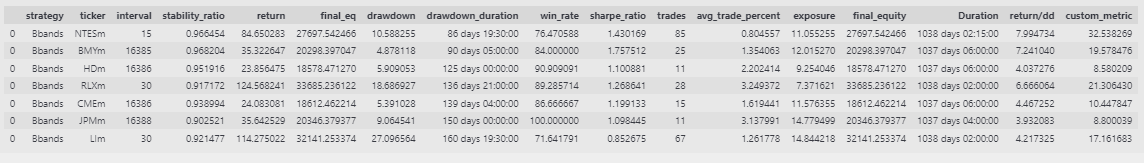
